In [ ]:
# Install adjustText
try: 
    import adjustText
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install adjustText
    import adjustText

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pylab import *

# SET PATH
PATH = "../data"

# Load Data

In [ ]:
freq_matrix_cats = pd.read_csv(f"{PATH}/freq_matrix_cats.csv", index_col = 0)
freq_matrix_names = pd.read_csv(f"{PATH}/freq_matrix_names.csv", index_col = 0)

# Distribution Analysis

In [ ]:
def make_count_df(freq_matrix, gender, intersection, CUM_THRESHOLD):
  '''Return counts and ranks of job distribution'''
  # Subset dataframe by intersection
  if intersection == 'continent':
    subset_df = freq_matrix.drop('name', axis = 1)
  elif intersection == 'average':
    subset_df = freq_matrix
  else:
    if intersection == 'religion':
      subs = ['buddhist','christian', 'hindu', 'muslim', 'jewish']
    elif intersection == 'ethnicity':
      subs = ['asian', 'black', 'hispanic', 'white']
    elif intersection == 'sexuality':
      subs = ['gay', 'straight']
    elif intersection == 'political':
      subs = ['conservative', 'liberal']
    elif intersection == 'base':
        subs = ['base'] 
    subset_df = freq_matrix[freq_matrix['category'].isin(subs)]  
  if gender != 'BOTH':
      subset_df = subset_df[subset_df['gender'] == gender]
  # Calculate counts and proportions per job
  subset_df = subset_df.set_index(['category', 'gender'])
  subset_df = subset_df.sum(axis = 0)
  subset_df = subset_df.reset_index()
  subset_df = subset_df.rename(columns = {'index': 'job', 0:'count'})
  subset_df = subset_df.sort_values(by = 'count', ascending = False)
  subset_df['share'] = subset_df['count']/subset_df['count'].sum()
  subset_df.index = pd.RangeIndex(start=1, stop=len(subset_df)+1, step=1)
  subset_df = subset_df.reset_index().rename(columns = {'index': 'rank'})
  # Keep cumulative > CUM_THRESHOLD:
  subset_df['cum_total'] = subset_df['share'].cumsum()
  cum_total = subset_df[subset_df['cum_total'] >= CUM_THRESHOLD]
  cum_total.index = pd.RangeIndex(start=0, stop=len(cum_total), step=1)
  xline = cum_total.iloc[0]['rank']
  yline = cum_total.iloc[0]['share']
  bar_points = [xline, yline]
  return subset_df, bar_points

In [ ]:
def threshold_check(freq_matrix, intersection, THRESHOLD):
  ''' Calculates cumulative proportion of jobs < THRESHOLD '''
  # Subset dataframe by intersection
  if intersection == 'continent':
    subset_df = freq_matrix
    subs = ['None']
  else:
    if intersection == 'religion':
      subs = ['christian', 'buddhist', 'hindu', 'jewish' ,'muslim']
    elif intersection == 'ethnicity':
      subs = ['asian', 'black', 'hispanic', 'white']
    elif intersection == 'sexuality':
      subs = ['gay', 'straight']
    elif intersection == 'political':
      subs = ['conservative', 'liberal']
    elif intersection == 'base':
        subs = ['base'] 
    subset_df = freq_matrix[freq_matrix['category'].isin(subs)]  
  df_frequency = subset_df.groupby(['category', 'gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  df_frequency = subset_df.groupby(['category','gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  # Remove jobs < THRESHOLD
  for token in df_frequency.columns:
    if df_frequency[token].aggregate(sum) < THRESHOLD:
      thresholds = thresholds.drop(columns = token)
  return thresholds, subs

In [ ]:
def threshold_tables(freq_matrix_cats, freq_matrix_names):
  ''' Prints threshold, total tokens and cumulative proportion < THRESHOLD'''
  intersections = ['base', 'ethnicity', 'religion', 'sexuality', 'political', 'continent']
  thresholds = [35, 140, 175, 70,70, 500]
  for intersection, THRESHOLD in zip(intersections, thresholds):
    if intersection == 'continent':
      thresholds= threshold_check(freq_matrix_names, intersection, THRESHOLD)[0]
      total_sum = thresholds.sum().sum()
      total_tokens = len(freq_matrix_names)
      print(total_tokens)
    else:
      thresholds, subs = threshold_check(freq_matrix_cats, intersection, THRESHOLD)
      total_sum = thresholds.sum().sum()
      total_tokens = len(freq_matrix_cats[freq_matrix_cats['category'].isin(subs)])
      total_tokens = len(freq_matrix_cats[freq_matrix_cats['category'].isin(subs)])                   
    print(f'{intersection}, threshold = {THRESHOLD}, total_tokens = {total_tokens}: proportion of counts {total_sum/total_tokens}')


In [ ]:
threshold_tables(freq_matrix_cats, freq_matrix_names)

base, threshold = 35, total_tokens = 17788: proportion of counts 0.8120643130200135
ethnicity, threshold = 140, total_tokens = 68239: proportion of counts 0.8243379885402775
religion, threshold = 175, total_tokens = 100910: proportion of counts 0.8420969180457833
sexuality, threshold = 70, total_tokens = 35830: proportion of counts 0.8331007535584706
political, threshold = 70, total_tokens = 32326: proportion of counts 0.8190311204603106
270320
continent, threshold = 500, total_tokens = 270320: proportion of counts 0.7573246522639834


## Distribution Plot

In [ ]:
intersections = ['base', 'sexuality', 'political','religion', 'ethnicity'] 
def make_rank_plot_all(logy = True, logx = True):
  '''Creates distribution plot for intersectional categories from ranks and cumulative share'''
  fig, ax = plt.subplots(1,1, figsize = (10,8))

  # Plot average distribution
  for gender in ['F', 'M']:
      color_dict = {'F': 'red', 'M': 'blue'}
      label_dict = {'F': 'Women (Average)', 'M': 'Men (Average)'}
      average_df, avg_bar_points = make_count_df(freq_matrix_cats, gender, 'average', 0.5)
      pct_bar_points = make_count_df(freq_matrix_cats, gender, 'average', 0.9)[1]
      average_df.plot('rank', 'share', logx = logx, logy = logy, ax = ax, label = label_dict[gender], color = color_dict[gender], alpha = 1, lw = 5)
      # Print labels and cumulative share of 50, 90 percentile
      print(label_dict[gender], avg_bar_points)
      print(label_dict[gender], pct_bar_points)
      # Plot 50 pct
      x_avg_line = (avg_bar_points[0], avg_bar_points[0])
      y_avg_line = (0, avg_bar_points[1])
      ax.plot(x_avg_line, y_avg_line, '--', alpha=1, color = color_dict[gender])

      # Plot 90 pct
      x_pct_line = (pct_bar_points[0], pct_bar_points[0])
      y_pct_line = (0, pct_bar_points[1])
      ax.plot(x_pct_line, y_pct_line, '--', alpha=1, color = color_dict[gender])
  
  # Plot intersectional lines
  for intersection in intersections:
    for gender in ['F', 'M']:
      count_df, bar_points = make_count_df(freq_matrix_cats, gender, intersection, 0.5)
      label = "_".join([intersection, gender])
      gender_labels = {'F': 'Woman', 'M': 'Man'}
      color_dict = {'F': 'red', 'M': 'blue'}
      count_df.plot('rank', 'share', logx = logx, logy = logy, ax = ax, color = color_dict[gender], alpha = 0.3)

  handles, labels = ax.get_legend_handles_labels()
  ax.get_legend().remove()
  fig.legend(handles[0:2], labels[0:2], fontsize = 16, ncol = 2, loc = 'upper center', bbox_to_anchor=(0.54, 0.96))
  ax.set_xlabel("Log(Rank)", fontsize = 16)
  ax.set_ylabel("Share of Total", fontsize = 16)
  ax.set_ylim(0, 0.18)
  ax.tick_params(axis = 'x', labelsize = 14)
  ax.tick_params(axis = 'y', labelsize = 14)

  # Annotations
  F_bar_points = make_count_df(freq_matrix_cats, 'F', 'average', 0.5)[1]
  F_pct_points = make_count_df(freq_matrix_cats, 'F', 'average', 0.9)[1]
  M_bar_points = make_count_df(freq_matrix_cats, 'M', 'average', 0.5)[1]
  M_pct_points = make_count_df(freq_matrix_cats, 'M', 'average', 0.9)[1]

  # Annotate 50%
  ax.annotate('16 jobs account for 50% of men',
          xy=(M_bar_points[0], M_bar_points[1]), xycoords='data',
          xytext=(0.43, 0.5), textcoords='axes fraction',
          arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
          horizontalalignment='left', verticalalignment='top', fontsize = 14)
  
  ax.annotate('8 jobs account for 50% of women',
        xy=(F_bar_points[0], F_bar_points[1]), xycoords='data',
        xytext=(0.335, 0.6), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
        horizontalalignment='left', verticalalignment='top', fontsize = 14)
  
  # Annotate 90%
  ax.annotate('66 jobs account for 90% of men',
        xy=(M_pct_points[0], M_pct_points[1]), xycoords='data',
        xytext=(0.624, 0.1), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
        horizontalalignment='left', verticalalignment='top', fontsize = 14)
  
  ax.annotate('43 jobs account for 90% of women',
        xy=(F_pct_points[0], F_pct_points[1]), xycoords='data',
        xytext=(0.565, 0.2), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width = 0.2, headwidth = 10),
        horizontalalignment='left', verticalalignment='top', fontsize = 14)

  plt.tight_layout()
  # fig.savefig(f'./figs/distributions_labelled.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

Women (Average) [8, 0.026148434690315168]
Women (Average) [43, 0.0035262229941317334]
Men (Average) [16, 0.022026051948723695]
Men (Average) [66, 0.0024741592599936205]


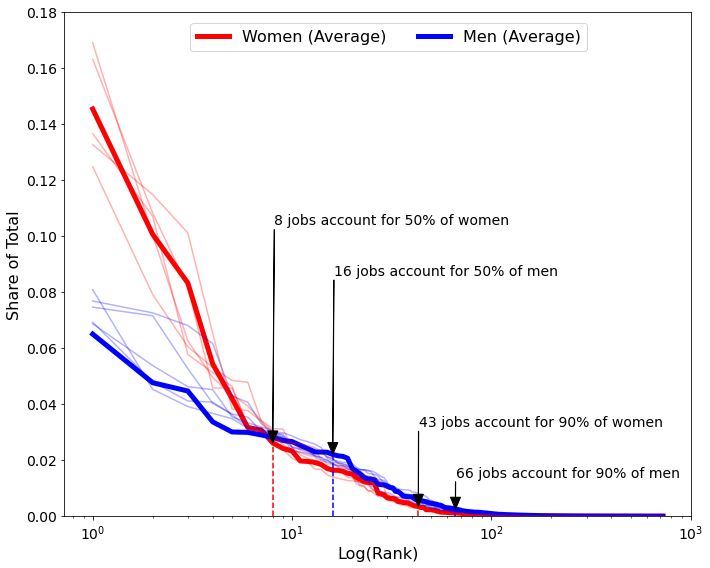

In [ ]:
make_rank_plot_all(logy=False, logx = True)

In [ ]:
intersections = ['base', 'ethnicity', 'religion', 'sexuality', 'political','continent']
def make_rank_plot_subplots(logy = True, logx = True):
  '''Creates distribution subplots for M,W for each intersection from ranks and cumulative share'''
  fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))
  ax = axes.ravel()
  for i, intersection in enumerate(intersections):
      for gender in ['F', 'M']:
        color_dict = {'F': 'red', 'M':'blue'}
        if intersection == 'continent':
          count_df = make_count_df(freq_matrix_names, gender, intersection, 0.5)[0]
        else:
          count_df= make_count_df(freq_matrix_cats, gender, intersection, 0.5)[0]
        label = "_".join([intersection, gender])
        label = label.replace('_F', '_W')  
        count_df.plot('rank', 'share', logx = logx, logy = logy, ax = ax[i], label = label, color = color_dict[gender])
        ax[i].set_xlabel("Log(Rank)", fontsize = 12)
        ax[i].set_ylabel("Share of Total", fontsize = 12)
        ax[i].set_ylim(0, 0.2)
        ax[i].legend(fontsize = 12)
  plt.tight_layout()
  # fig.savefig(f'./figs/appendix_figs/distributions_subplots.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

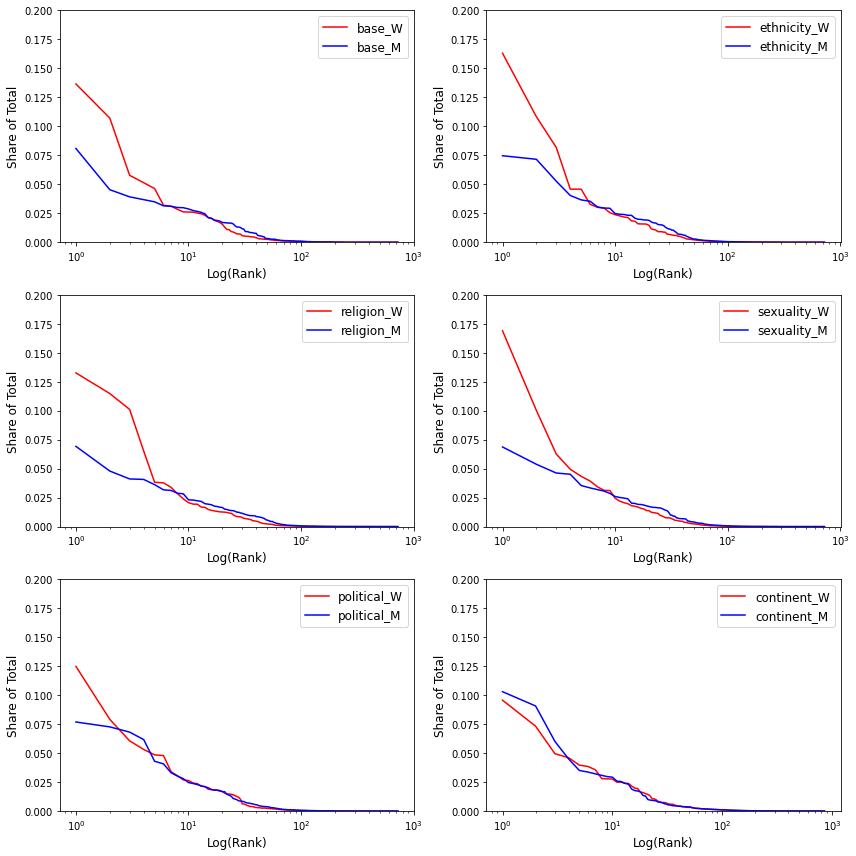

In [ ]:
make_rank_plot_subplots(logy=False, logx = True)

## Gini and Lorenz Curve

In [ ]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [ ]:
intersections = ['base', 'ethnicity', 'religion', 'sexuality', 'political','continent']
def plot_lorenz_curve(zoom = False):
  '''Creates lorenz curve plot for base M, base W from ranks and cumulative share'''
  fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))
  ax = axes.ravel()
  for i, intersection in enumerate(intersections):
    for gender in ['F', 'M']:
      color_map = {'F':'red', 'M': 'blue'}
      if intersection == 'continent':
        count_df = make_count_df(freq_matrix_names, gender, intersection, 0.5)[0]
      else:
        count_df = make_count_df(freq_matrix_cats, gender, intersection, 0.5)[0]
      share_array = np.array(count_df['share'])
      X_lorenz = count_df['share'].cumsum() / count_df['share'].sum()
      label = "_".join([intersection, gender])
      label = label.replace('_F', '_W')  
      ax[i].scatter(X_lorenz, np.arange(X_lorenz.size)/(X_lorenz.size-1), 
            marker='x', color=color_map[gender], s=20, label = label)
      # Set zoom to focus on smaller y-axis range
      if zoom == True:
        ax[i].set_ylim([-0.01, 0.2])
      else:
        ax[i].set_ylim([-0.05,1.05])
        ax[i].plot([0,1], [0,1], ls='--', color = 'black')
      ax[i].set_ylabel('Cumulative Share of Jobs', fontsize = 12)
      ax[i].set_xlabel('Cumulative Share of Total Workers', fontsize = 12)
      ax[i].legend(fontsize = 12)
  plt.tight_layout()
  # fig.savefig(f'./figs/appendix_figs/lorenz_curve_subplots_zoom_{zoom}.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

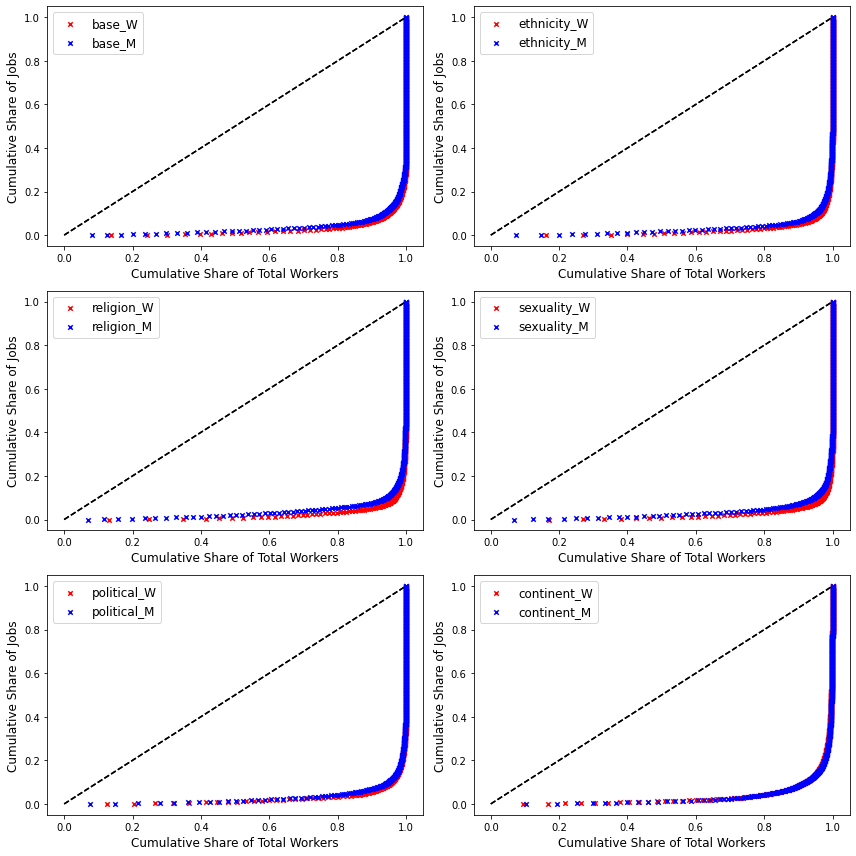

In [ ]:
plot_lorenz_curve(zoom = False)

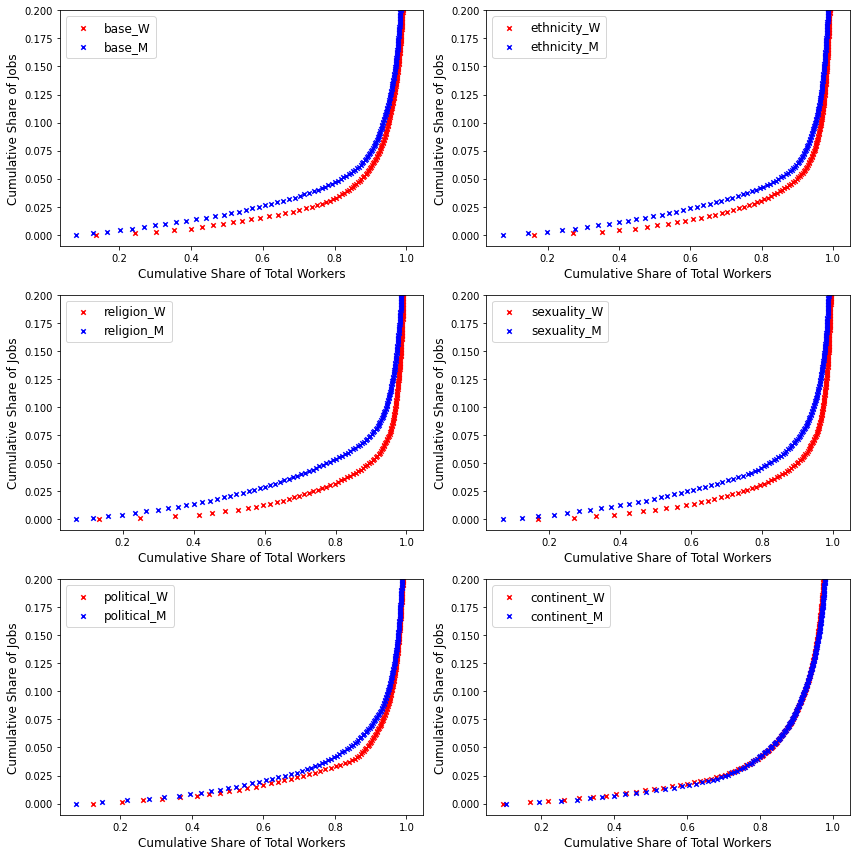

In [ ]:
plot_lorenz_curve(zoom = True)

In [ ]:
def return_gini(freq_matrix_cats, gender, intersection):
  '''Calculates gini_coefficient for gender-intersection pair'''
  count_df, bar_points = make_count_df(freq_matrix_cats, gender, intersection, 0.5)
  share_array = np.array(count_df['share'])
  return gini(share_array)

In [ ]:
intersections = ['base', 'sexuality', 'political','religion', 'ethnicity'] 
def gini_table():
  '''Returns dataframe of gini coefficients'''
  gender_list = []
  intersection_list = []
  gini_list = []
  for gender in ['F', 'M']:
    for intersection in intersections:
      gini = return_gini(freq_matrix_cats, gender, intersection)
      gender_name = {'F':'Woman', 'M': 'Man'}
      gender_list.append(gender_name[gender])
      intersection_list.append(intersection.capitalize())
      gini_list.append(np.round(gini,3))
  results = pd.DataFrame({'gender':gender_list, 'intersection':intersection_list, 'gini_coeff':gini_list})
  results = results.sort_values(by = 'gini_coeff', ascending = False)
  return results

In [ ]:
# Calculate gini coefficients
results = gini_table()
results.index = pd.RangeIndex(start = 0, stop = len(results),step=1)
# Reindex coefficients relative to base_M, base_W
woman_index_value = 100/results['gini_coeff'].iloc[3]
man_index_value = 100/results['gini_coeff'].iloc[8]
results['relative_to_baseM'] = np.round(results['gini_coeff'] * man_index_value,2)
# Export gini table
# results.to_csv('./data/gini_results.csv')

# Output Graphs

## Set Default Parameters

In [ ]:
#--->> DEFAULT PARAMETERS #
THRESHOLD = 500                           # remove all tokens whose cumulative sum (vertically) is below this threshold
TOP_N = 15                              # after the analysis, the number of tokens to be picked and ranked for each category (and showed in plots)

#--->> CREATING LABELS AND SETTING FONT SIZE FOR PLOTS BELOW
x_TICK_NUMBER = list(range(TOP_N))        # to create visual aids on plots (numbers on x-axis)
FONTSIZE = 14                             # set the font size for plots


## Select Plot Data

In [ ]:
def select_plot_df(freq_matrix, intersection, criteria, THRESHOLD, TOP_N):
  '''Subsets dataframe for subsequent plots

  Args:
    freq_matrix: input one-hot encoded job matrix
    intersection: category for analysis from ['base', 'ethnicity', 'religion', 'sexuality', 'political', 'continent']
    criteria: method of selecting large man-woman difference by min-max range ('range') or standard deviation ('std')
    THRESHOLD: lower-bound of mentions to exclude infrequently mentioned jobs'
    TOP_N: Number of jobs to retain for plot.
    '''
  # Subset dataframe by intersection
  if intersection == 'continent':
    subset_df = freq_matrix
  else:
    if intersection == 'religion':
      subs = ['christian', 'buddhist', 'hindu', 'jewish' ,'muslim']
    elif intersection == 'ethnicity':
      subs = ['asian', 'black', 'hispanic', 'white']
    elif intersection == 'sexuality':
      subs = ['gay', 'straight']
    elif intersection == 'political':
      subs = ['conservative', 'liberal']
    elif intersection == 'base':
        subs = ['base'] 
    subset_df = freq_matrix[freq_matrix['category'].isin(subs)]
  df_frequency = subset_df.groupby(['category', 'gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  # Apply threshold
  for token in df_frequency.columns:
    if df_frequency[token].aggregate(sum) < THRESHOLD:
      thresholds = thresholds.drop(columns = token)
  proportions = thresholds.div(thresholds.aggregate(sum))
  print(f'Number of categories: {proportions.shape[0]}, Number of Jobs > THRESHOLD: {proportions.shape[1]}')
  # Selection criteria
  if criteria == 'range':
    selection = proportions.aggregate(max) - proportions.aggregate(min)
  if criteria == 'std':
    selection = proportions.aggregate(np.std)
  # Apply TOP-N and sort
  if TOP_N == 'NONE':
    selection = selection.sort_values(ascending = False)
  else:
    selection = selection.sort_values(ascending = False)
    selection = selection.nlargest(TOP_N)
  # Make dataFrame
  plot_df = proportions[list(selection.index)]
  idx_ref = plot_df.groupby('gender').aggregate(sum).loc['M'].sort_values(ascending = False).index
  plot_df = plot_df.loc[:, (idx_ref)]

  return plot_df

## Gender Parity

In [ ]:
def gender_parity_bar(freq_matrix, criteria, THRESHOLD, TOP_N):
  '''Creates barplot of top man-woman range for TOP_N jobs under THRESHOLD, selected by range or std criteria'''
  # Select plot data
  plot_df = select_plot_df(freq_matrix, 'base', criteria, THRESHOLD, TOP_N)
  plot_df = plot_df.aggregate(np.diff).aggregate(sum)
  # Set up subplots
  N_PLOTS = 1
  labels_plot = plot_df.index
  fig, ax = plt.subplots(nrows = N_PLOTS, figsize = (20, 3))
  x_TICK_NUMBER = list(range(TOP_N))
  print(f"Caption title:\nGender parity of {TOP_N} jobs.\nThreshold = {THRESHOLD}, criteria = {criteria}")
  # Plot bar
  ax.bar(x_TICK_NUMBER, plot_df.values, color = 'black', alpha = 0.7, zorder = 5)
  plt.sca(ax)
  plt.xticks(range(TOP_N), color = 'grey')
  plt.yticks([1,0,-1], labels = ['100% Men', 'Gender Parity', '100% Women'], fontsize = 14)          
  ax.grid(which = 'both', color = 'lightgrey', alpha = 0.5)
  ax.set_xlim((-1,TOP_N))
  ax.set_ylim((-1.05, 1.05))
  plt.hlines(0, -0.5, TOP_N-0.5, colors = 'red', linestyles = 'dashdot', zorder = 6)      # label = 'gender parity line',
  plt.text(0, -0.2, "Male-dominated jobs", color = 'red', fontsize = FONTSIZE)
  plt.text(51, 0.2, "Female-dominated jobs", color = 'red', fontsize = FONTSIZE)
  plt.xticks(x_TICK_NUMBER, labels_plot, rotation = 90, fontsize = FONTSIZE, color = 'black')
  # fig.savefig(f'./figs/gender_parity.pdf', format='pdf', dpi=900, bbox_inches='tight')
  plt.show()

Number of categories: 2, Number of Jobs > THRESHOLD: 61
Caption title:
Gender parity of 61 jobs.
Threshold = 35, criteria = range


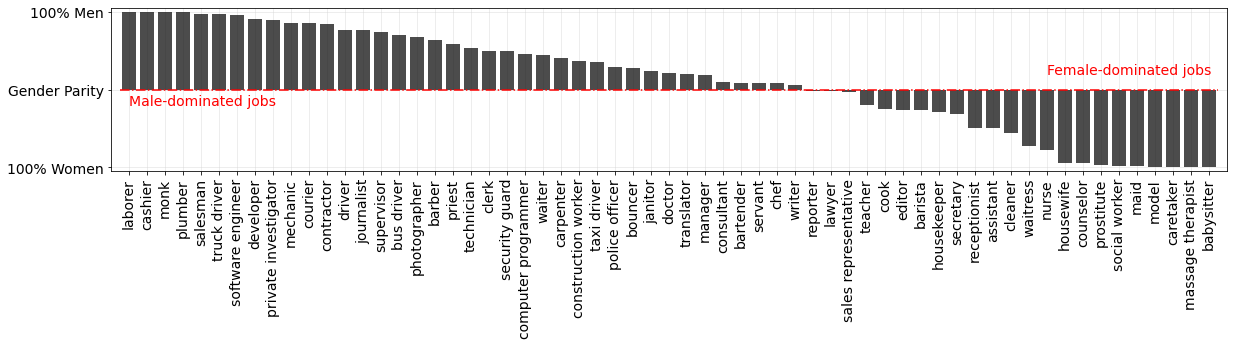

In [ ]:
gender_parity_bar(freq_matrix_cats, "range", 35, 61)

## Stacked Bars

In [ ]:
def stacked_bar(freq_matrix, intersection, criteria, THRESHOLD, TOP_N):
  ''' Creates stacked-bar chart by intersection for TOP_N jobs under THRESHOLD, selected by range or std criteria'''
  # Select plot data
  plot_df = select_plot_df(freq_matrix, intersection, criteria, THRESHOLD, TOP_N)
  # Set up subplots
  N_PLOTS = 2
  plot_labels = plot_df.columns.tolist()
  fig, axes = plt.subplots(nrows = N_PLOTS, figsize = (20, 8))
  x_TICK_NUMBER = list(range(TOP_N))
  print(f"Caption title:\nTop {TOP_N} jobs by gender and {intersection.upper()}.\nThreshold = {THRESHOLD}, criteria = {criteria}\n")
  # Initialise caches 
  array_dict = {}
  labels = []  
  k = 0
  # Plot bar
  for gender in sorted(list(set(plot_df.reset_index()['gender']))):
    array_meta = np.zeros(TOP_N)
    array_dict[gender] = np.empty((0,TOP_N))
    j = 0
    for category in sorted(list(set(plot_df.reset_index()['category']))):
      label = category.capitalize()
      array_dict[gender] = np.append(array_dict[gender], np.array([plot_df.loc[category, gender].values]), axis=0)
      labels.append(label)
      axes[k].bar(x_TICK_NUMBER, array_dict[gender][j], bottom = array_meta, label = label, width = 0.85, alpha = 0.7, lw = 1, edgecolor = 'black', zorder = 6)
      array_meta = array_meta + array_dict[gender][j]
      j += 1
    k += 1
  # Set axes and legend
  genders = ['Woman', 'Man']
  for idx, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.xticks(range(TOP_N), color = 'white')
    plt.yticks(np.arange(0, 1.05, 0.2))
    ax.grid(which = 'both', color = 'lightgrey', alpha = 0.5)
    ax.set_xlim((-1, TOP_N))
    ax.set_ylim((0, 1.05))
    ax.set_title(genders[idx], fontsize = 16)
    ax.tick_params(axis = 'y', labelsize = 14)
  handles, labels = ax.get_legend_handles_labels()
  if intersection == 'religion':
    fig.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper center')
  elif intersection == 'continent':
    fig.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper center')
  elif intersection == 'sexuality':
    labels = ['Lesbian/Gay', 'Straight']
    fig.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper center')
  else:
    fig.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper center')
  plt.sca(axes[N_PLOTS - 1])
  plt.xticks(x_TICK_NUMBER, plot_labels, rotation = 90, fontsize = 14, color = 'black')
  fig.savefig(f'./figs/appendix_figs/full_barplot_{intersection}.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

Number of categories: 10, Number of Jobs > THRESHOLD: 62
Caption title:
Top 62 jobs by gender and CONTINENT.
Threshold = 500, criteria = range



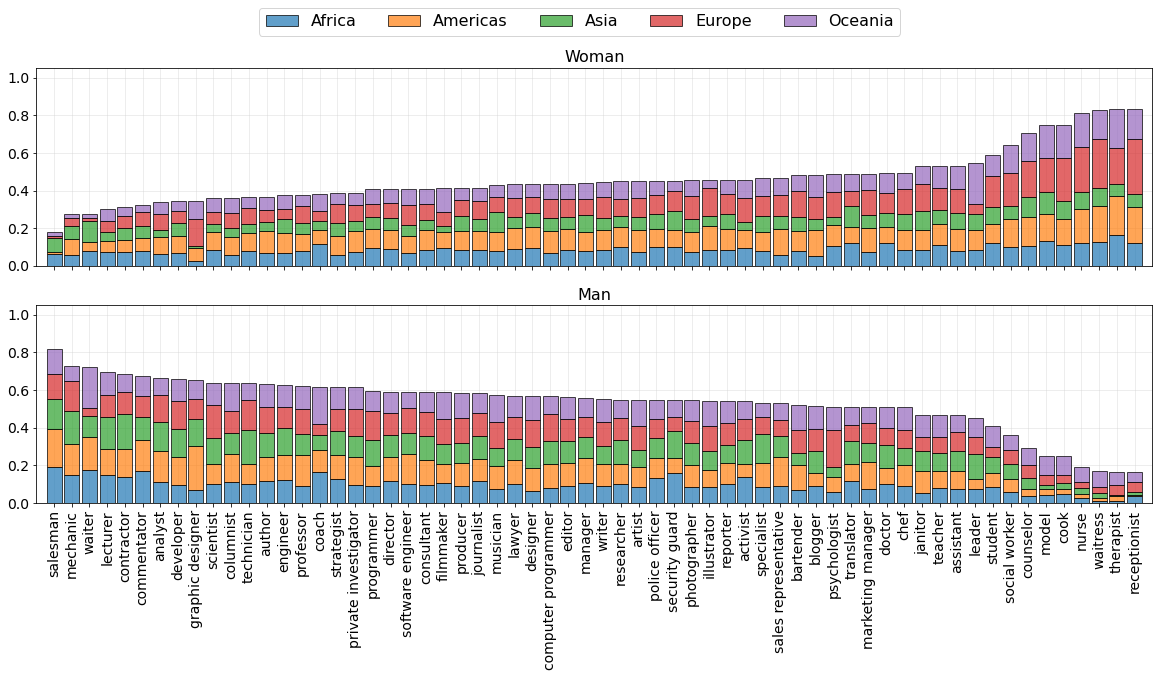

In [ ]:
stacked_bar(freq_matrix_names, 'continent', 'range', 500, 62)

Number of categories: 10, Number of Jobs > THRESHOLD: 69
Caption title:
Top 69 jobs by gender and RELIGION.
Threshold = 175, criteria = range



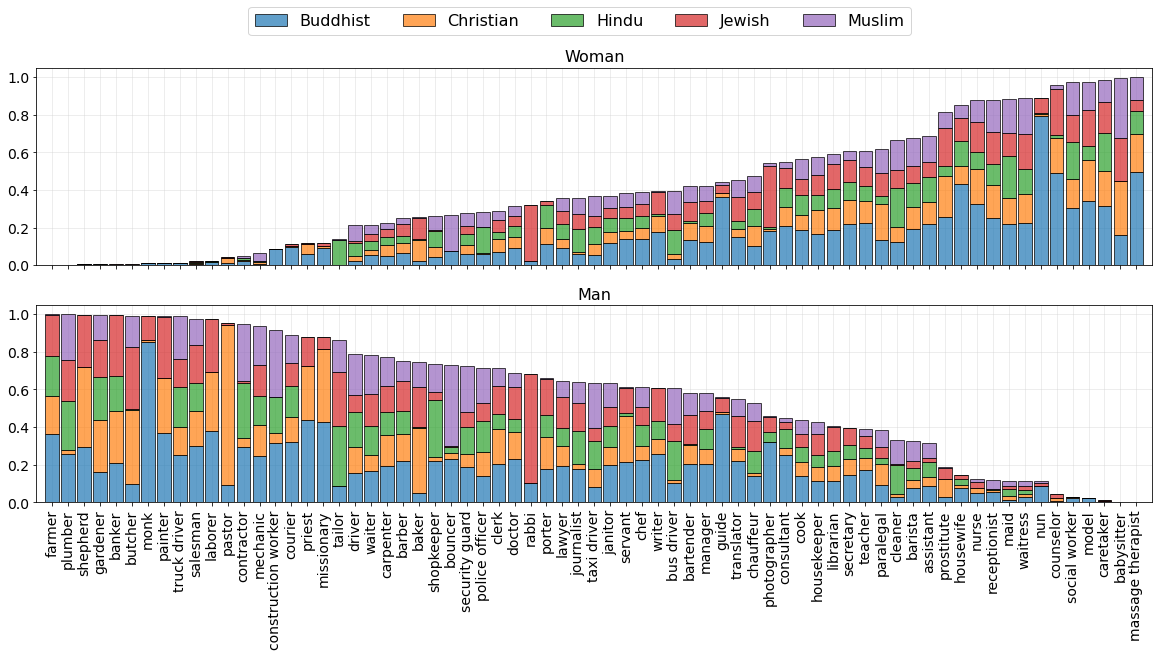

In [ ]:
stacked_bar(freq_matrix_cats, 'religion', 'range', 175, 69)

Number of categories: 8, Number of Jobs > THRESHOLD: 52
Caption title:
Top 52 jobs by gender and ETHNICITY.
Threshold = 140, criteria = range



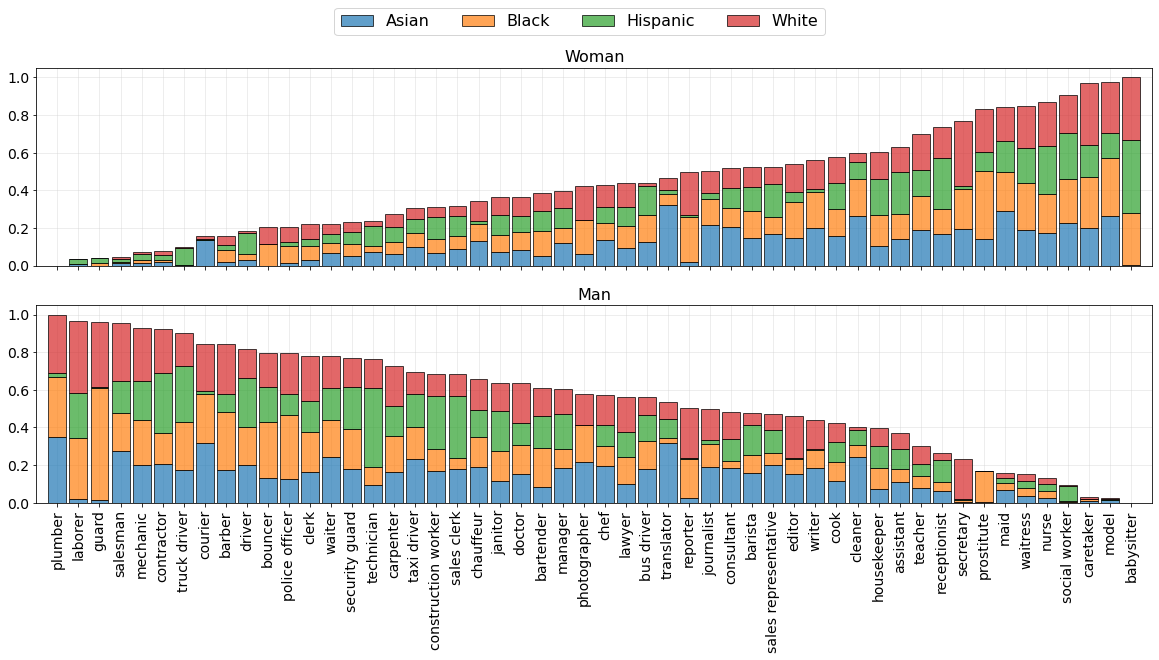

In [ ]:
stacked_bar(freq_matrix_cats, 'ethnicity', 'range', 140, 52)

Number of categories: 4, Number of Jobs > THRESHOLD: 60
Caption title:
Top 60 jobs by gender and SEXUALITY.
Threshold = 70, criteria = range



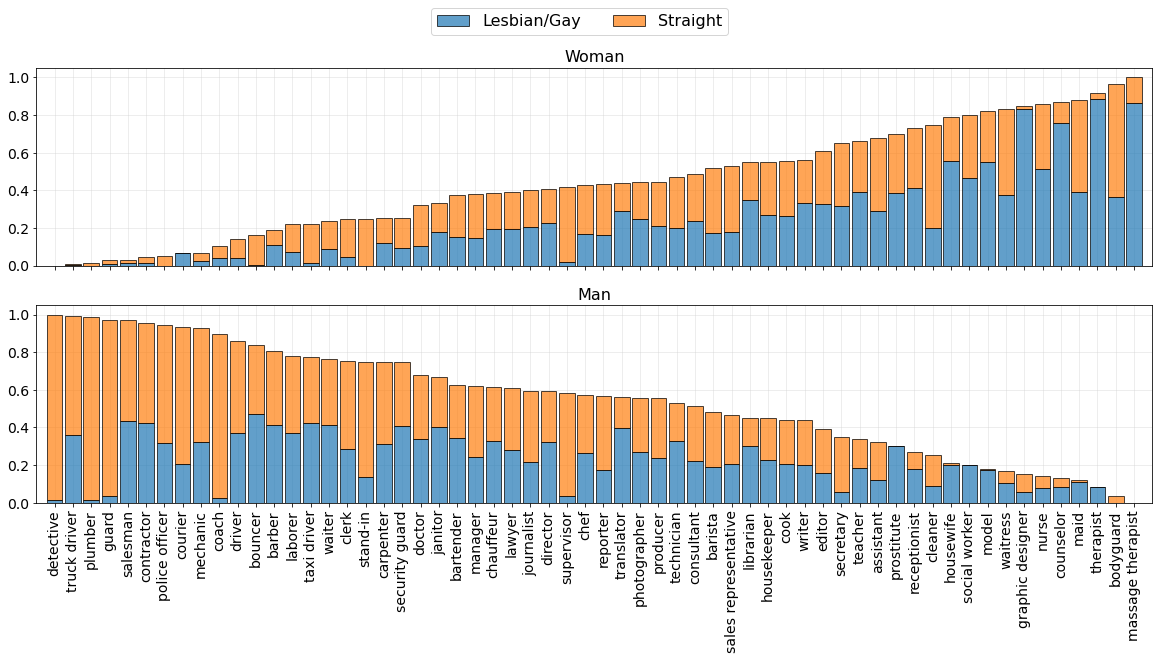

In [ ]:
stacked_bar(freq_matrix_cats, 'sexuality', 'range', 70, 60)

Number of categories: 4, Number of Jobs > THRESHOLD: 55
Caption title:
Top 55 jobs by gender and POLITICAL.
Threshold = 70, criteria = range



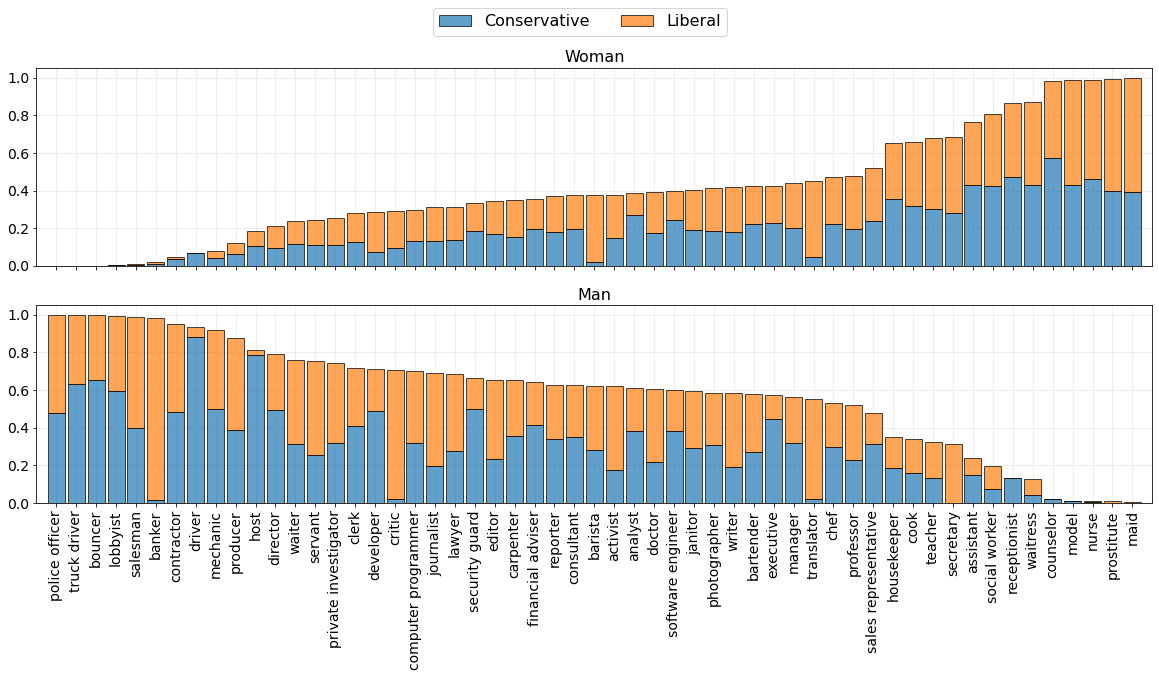

In [ ]:
stacked_bar(freq_matrix_cats, 'political', 'range', 70, 55)

## Scatter Plots

In [ ]:
def scatter_plot(freq_matrix_cats, intersection, criteria, THRESHOLD, TOP_N):
  '''Creates scatterplot by intersection for TOP_N jobs under THRESHOLD, selected by range or std criteria'''
  # Select plot data
  subset_df = select_plot_df(freq_matrix_cats, intersection, criteria, THRESHOLD, TOP_N)
  subset_df = subset_df.reset_index()
  # Create list of jobs
  jobs_list = list(subset_df.columns)
  jobs_list.remove('gender')
  jobs_list.remove('category')
  frames = []
  for job in jobs_list:
    job_df = subset_df.pivot(index='category', columns='gender')[(job)].reset_index()
    job_df['job'] = job
    job_df = job_df.set_index('job')
    frames.append(job_df)
  all_jobs = pd.concat(frames)
  # Make plot
  fig, ax = plt.subplots(1,1, figsize = (8,8))
  xs = all_jobs['F']
  ys = all_jobs['M']
  sns.scatterplot(x=xs, y=ys, data=all_jobs, hue='category', marker="x", ax = ax)
  ax.set_xlabel("Share of Women", fontsize = 14)
  ax.set_ylabel("Share of Men", fontsize = 14)
  ax.set_xlim(-0.05,1)
  ax.set_ylim(-0.05,1)
  # Legend
  handles, labels = ax.get_legend_handles_labels()
  labels = [s.capitalize() for s in labels]
  if intersection == 'religion':
    plt.legend(handles, labels, fontsize = 12, ncol = 3, loc = 'upper center')
  elif intersection == 'continent':
    plt.legend(handles, labels, fontsize = 12, ncol = 3, loc = 'upper center')
  elif intersection == 'sexuality':
    labels = ['Lesbian/Gay', 'Straight']
    plt.legend(handles, labels, fontsize = 12, ncol = 3, loc = 'upper center')
  else:
    plt.legend(handles, labels, fontsize = 12, ncol = len(labels), loc = 'upper center')
  # Plot no-bias line
  x_line = [1*(1/len(labels)), 0]
  y_line = [0, 1*(1/len(labels))]
  ax.plot(x_line, y_line, '--', alpha=0.75, zorder=0, color = 'black')
  # Annotations
  all_jobs['diff'] = all_jobs['M'] - all_jobs['F']
  all_jobs = all_jobs.sort_values(by ="diff", ascending = False)
  jobs_list = list(all_jobs.index)
  together = []
  for i in range(-1, -4, -1):
    label = jobs_list[i]
    x = all_jobs['F'].iloc[i]
    y = all_jobs['M'].iloc[i]
    together.append((label,x,y))
  #Add male labels
  for i in range(0, 5, 1):
    label = jobs_list[i]
    x = all_jobs['F'].iloc[i]
    y = all_jobs['M'].iloc[i]
    together.append((label, x,y))
  together.sort()
  text = [x for (x,y,z) in together]
  xs = [y for (x,y,z) in together]
  ys = [z for (x,y,z) in together]
  texts = []
  for x, y, s in zip(xs, ys, text):
      texts.append(plt.text(x, y, s))
  adjust_text(texts, x=xs, y=ys, autoalign='xy',only_move={'points':'y', 'text':'x'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5),force_text=0.5)
  plt.tight_layout()
  fig.savefig(f'./figs/scatterplot_{intersection}.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

Number of categories: 10, Number of Jobs > THRESHOLD: 69


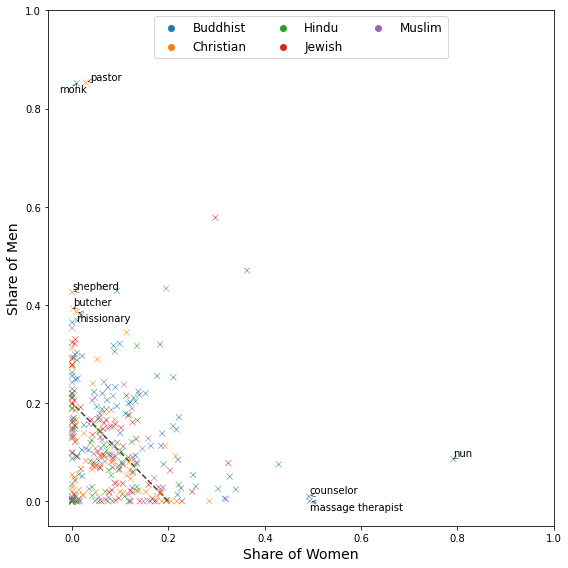

In [ ]:
scatter_plot(freq_matrix_cats, 'religion', 'range', 175, 'NONE')

Number of categories: 8, Number of Jobs > THRESHOLD: 52


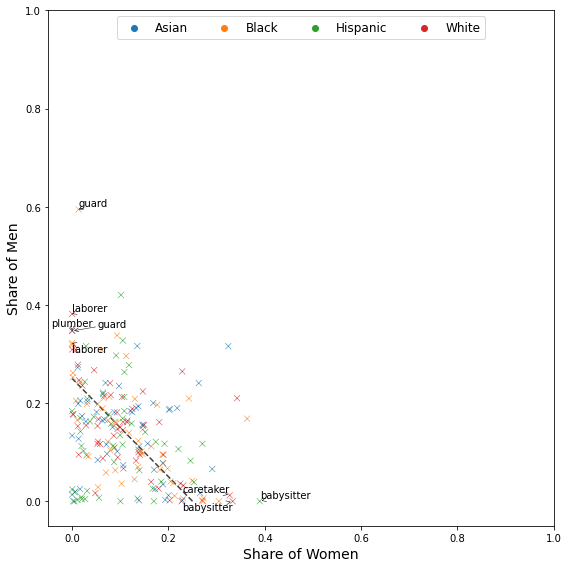

In [ ]:
scatter_plot(freq_matrix_cats, 'ethnicity', 'range', 140, 'NONE')

Number of categories: 4, Number of Jobs > THRESHOLD: 60


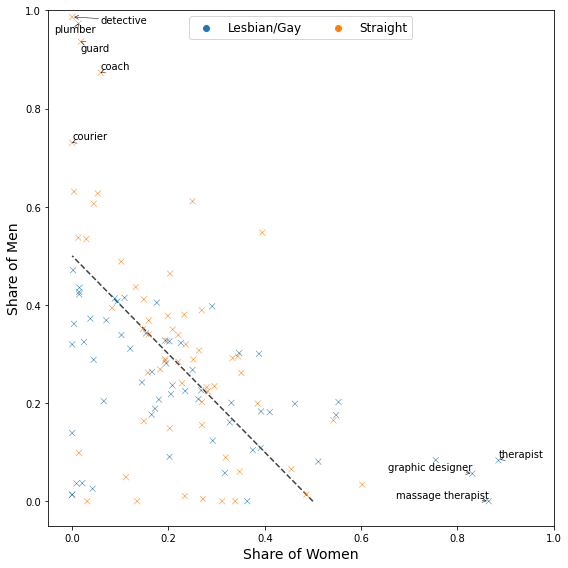

In [ ]:
scatter_plot(freq_matrix_cats, 'sexuality', 'range', 70, 'NONE')

Number of categories: 4, Number of Jobs > THRESHOLD: 55


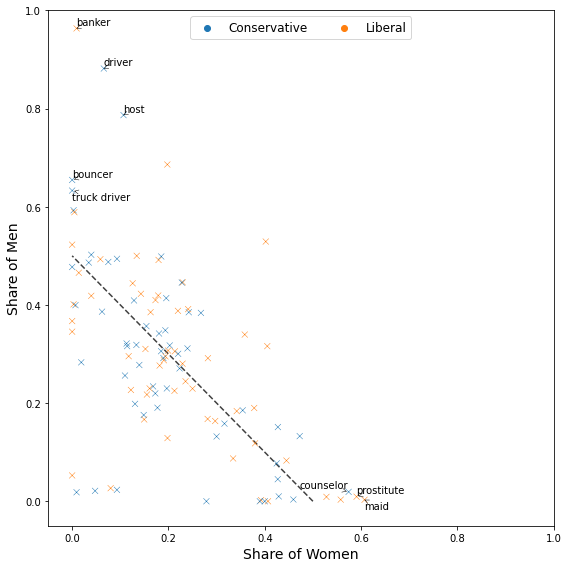

In [ ]:
scatter_plot(freq_matrix_cats, 'political', 'range', 70, 'NONE')

Number of categories: 10, Number of Jobs > THRESHOLD: 62


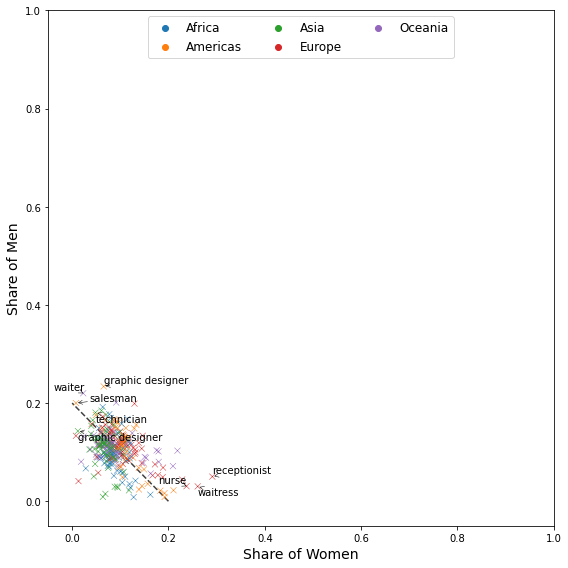

In [ ]:
scatter_plot(freq_matrix_names, 'continent', 'range', 500, 'NONE')

## Bar and Scatter

In [ ]:
def make_bar_scatter(freq_matrix, intersection, criteria, THRESHOLD):
  ''' Creates 3-subplots, with LHS = scatter, RHS = 2 x stacked bars of TOP-N jobs under THRESHOLD by man-woman range'''
  # Set up 3-part figure grid
  fig3 = plt.figure(constrained_layout=False, figsize = (10,7))
  gs = fig3.add_gridspec(ncols=10, nrows=7)
  f3_ax1 = fig3.add_subplot(gs[:, 0:6])
  f3_ax1.set_title('')
  f3_ax2 = fig3.add_subplot(gs[0:3, 6:10])
  f3_ax2.set_title('bar1')
  f3_ax3 = fig3.add_subplot(gs[3:6, 6:10])
  f3_ax3.set_title('bar2')
  gs.update(wspace=1.5, hspace=1.5)

  ## BAR PLOTS
  # Make plotting df
  plot_df = select_plot_df(freq_matrix, intersection, criteria, THRESHOLD, 10)
  # Set up subplots
  TOP_N = 10
  plot_labels = plot_df.columns.tolist()
  x_TICK_NUMBER = list(range(TOP_N))
  # Initialise caches
  array_dict = {}
  labels = []  
  bar_axes = [f3_ax2, f3_ax3]
  # Make bar plot
  k = 0
  for gender in sorted(list(set(plot_df.reset_index()['gender']))):
    array_meta = np.zeros(TOP_N)
    array_dict[gender] = np.empty((0,TOP_N))
    j = 0
    for category in sorted(list(set(plot_df.reset_index()['category']))):
      label = category.capitalize()
      array_dict[gender] = np.append(array_dict[gender], np.array([plot_df.loc[category, gender].values]), axis=0)
      labels.append(label)
      bar_axes[k].bar(x_TICK_NUMBER, array_dict[gender][j], bottom = array_meta, label = label, width = 0.85, alpha = 0.7, lw = 1, edgecolor = 'black', zorder = 6)
      array_meta = array_meta + array_dict[gender][j]
      j += 1
    k += 1

  # Axes
  genders = ['Woman', 'Man']
  for idx, ax in enumerate(bar_axes):
    plt.sca(ax)
    plt.xticks(range(TOP_N), color = 'white')
    plt.yticks(np.arange(0, 1.05, 0.2))
    ax.grid(which = 'both', color = 'lightgrey', alpha = 0.5)
    ax.set_xlim((-1, TOP_N))
    ax.set_ylim((0, 1.05))
    ax.set_title(genders[idx], fontsize = 16)
    ax.tick_params(axis = 'y', labelsize = 14)
  N_PLOTS = 2
  plt.sca(bar_axes[N_PLOTS - 1])
  plt.xticks(x_TICK_NUMBER, plot_labels, rotation = 90, fontsize = 16, color = 'black')

  ## SCATTER PLOT
  # Select plot data
  subset_df = select_plot_df(freq_matrix, intersection, criteria, THRESHOLD, 'NONE')
  subset_df = subset_df.reset_index()
  # Create list of jobs
  jobs_list = list(subset_df.columns)
  jobs_list.remove('gender')
  jobs_list.remove('category')
  frames = []
  for job in jobs_list:
    job_df = subset_df.pivot(index='category', columns='gender')[(job)].reset_index()
    job_df['job'] = job
    job_df = job_df.set_index('job')
    frames.append(job_df)
  all_jobs = pd.concat(frames)
  # Make scatter plot
  xs = all_jobs['F']
  ys = all_jobs['M']
  f3_ax1.set_xlabel("Over-representation Factor (Women)", fontsize = 16)
  f3_ax1.set_ylabel("Over-representation Factor (Men)", fontsize = 16)
  f3_ax1.set_xlim(-0.05,1)
  f3_ax1.set_ylim(-0.05,1)
  f3_ax1.tick_params(axis = 'x', labelsize = 14)
  f3_ax1.tick_params(axis = 'y', labelsize = 14)
  sns.scatterplot(x=xs, y=ys, data=all_jobs, hue='category', marker="x", ax = f3_ax1)

  # Annotations
  all_jobs['diff'] = all_jobs['M'] - all_jobs['F']
  all_jobs = all_jobs.sort_values(by ="diff", ascending = False)
  jobs_list = list(all_jobs.index)
  together = []
  # Woman-dominated jobs
  for i in range(-1, -5, -1):
    label = jobs_list[i]
    x = all_jobs['F'].iloc[i]
    y = all_jobs['M'].iloc[i]
    together.append((label,x,y))
  #Man-dominated jobs
  for i in range(0, 4, 1):
    label = jobs_list[i]
    x = all_jobs['F'].iloc[i]
    y = all_jobs['M'].iloc[i]
    together.append((label, x,y))
  together.sort()
  text = [x for (x,y,z) in together]
  xs = [y for (x,y,z) in together]
  ys = [z for (x,y,z) in together]
  texts = []
  for x, y, s in zip(xs, ys, text):
      texts.append(f3_ax1.text(x, y, s, fontsize = 14))

  # Legend
  handles, labels = f3_ax1.get_legend_handles_labels()
  f3_ax1.get_legend().remove()
  labels = [s.capitalize() for s in labels]
  if intersection == 'religion':
    fig3.legend(handles, labels, fontsize = 16, ncol = 1, loc = 'upper right', bbox_to_anchor=(0.51, 0.95))
  elif intersection == 'continent':
    fig3.legend(handles, labels, fontsize = 16, ncol = 1, loc = 'upper right', bbox_to_anchor=(0.51, 0.93))
  elif intersection == 'sexuality':
    labels = ['Lesbian/Gay', 'Straight']
    fig3.legend(handles, labels, fontsize = 16, ncol = 1, loc = 'upper right', bbox_to_anchor=(0.51, 0.95))
  elif intersection == 'political':
    fig3.legend(handles, labels, fontsize = 16, ncol = 1, loc = 'upper right', bbox_to_anchor=(0.51, 0.84))
  else:
    fig3.legend(handles, labels, fontsize = 16, ncol = 1, loc = 'upper right', bbox_to_anchor=(0.51, 0.86))

  # INLINE LABELS
  # if intersection == 'religion':
  #   fig3.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper left', bbox_to_anchor=(0, 1.1))
  # elif intersection == 'sexuality':
  #   labels = ['Lesbian/Gay', 'Straight']
  #   fig3.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper left', bbox_to_anchor=(0.2, 1.1))
  # elif intersection == 'political':
  #   fig3.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper center')
  # elif intersection == 'continent':
  #   fig3.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper left', bbox_to_anchor=(0, 1.1))
  # else:
  #   fig3.legend(handles, labels, fontsize = 16, ncol = len(labels), loc = 'upper left', bbox_to_anchor=(0.1, 1.02))
  # Lines
  x_line = [1*(1/len(labels)), 0]
  y_line = [0, 1*(1/len(labels))]
  f3_ax1.plot(x_line, y_line, '--', alpha=0.9, zorder=0, color = 'black')

  # Scale axis
  if intersection == 'religion':
    scale_factor = 5*(1/len(labels))
    f3_ax1.set_xlim(-0.05,scale_factor)
    f3_ax1.set_ylim(-0.05,scale_factor)
    f3_ax1.set_xticks([0, scale_factor/5, ((scale_factor/5) * 2), ((scale_factor/5) * 3), ((scale_factor/5) * 4), scale_factor])
    f3_ax1.set_xticklabels(['0x','1x', '2x', '3x', '4x', '5x'])
    f3_ax1.set_yticks([0, scale_factor/5, ((scale_factor/5) * 2), ((scale_factor/5) * 3), ((scale_factor/5) * 4), scale_factor])
    f3_ax1.set_yticklabels(['0x','1x', '2x', '3x', '4x', '5x'])
  elif intersection == 'ethnicity':
    scale_factor = 3*(1/len(labels))
    f3_ax1.set_xlim(-0.05,scale_factor)
    f3_ax1.set_ylim(-0.05,scale_factor)
    f3_ax1.set_xticks([0, scale_factor/3, ((scale_factor/3) * 2), scale_factor])
    f3_ax1.set_xticklabels(['0x','1x', '2x', '3x'])
    f3_ax1.set_yticks([0, scale_factor/3, ((scale_factor/3) * 2), scale_factor])
    f3_ax1.set_yticklabels(['0x','1x', '2x', '3x'])
  elif intersection == 'continent':
    scale_factor = 2*(1/len(labels))
    f3_ax1.set_xlim(-0.025,scale_factor)
    f3_ax1.set_ylim(-0.025,scale_factor)
    f3_ax1.set_xticks([0, scale_factor/2, scale_factor])
    f3_ax1.set_xticklabels(['0x','1x','2x'])
    f3_ax1.set_yticks([0, scale_factor/2, scale_factor])
    f3_ax1.set_yticklabels(['0x','1x','2x'])
  else:
    scale_factor = 2*(1/len(labels))
    f3_ax1.set_xlim(-0.05,scale_factor)
    f3_ax1.set_ylim(-0.05,scale_factor)
    f3_ax1.set_xticks([0, scale_factor/2, scale_factor])
    f3_ax1.set_xticklabels(['0x','1x','2x'])
    f3_ax1.set_yticks([0, scale_factor/2, scale_factor])
    f3_ax1.set_yticklabels(['0x','1x','2x'])


  adjust_text(texts, x=xs, y=ys, ax=f3_ax1, autoalign='y',only_move={'points':'xy', 'text':'xy'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
  fig3.savefig(f'./figs/scatterbar_{intersection}.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

Number of categories: 8, Number of Jobs > THRESHOLD: 48
Number of categories: 8, Number of Jobs > THRESHOLD: 48


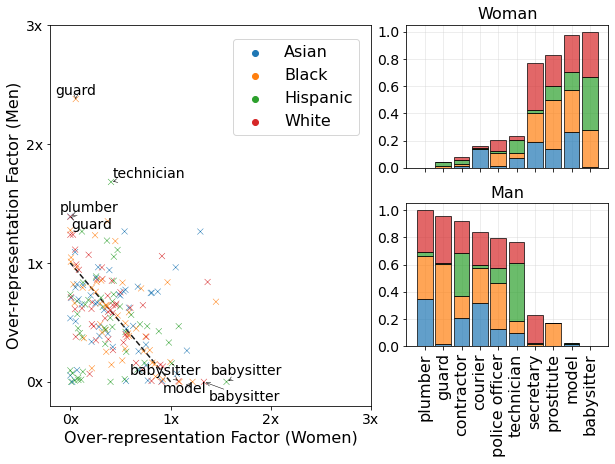

In [ ]:
make_bar_scatter(freq_matrix_cats, 'ethnicity', 'range', 175)

Number of categories: 10, Number of Jobs > THRESHOLD: 69
Number of categories: 10, Number of Jobs > THRESHOLD: 69


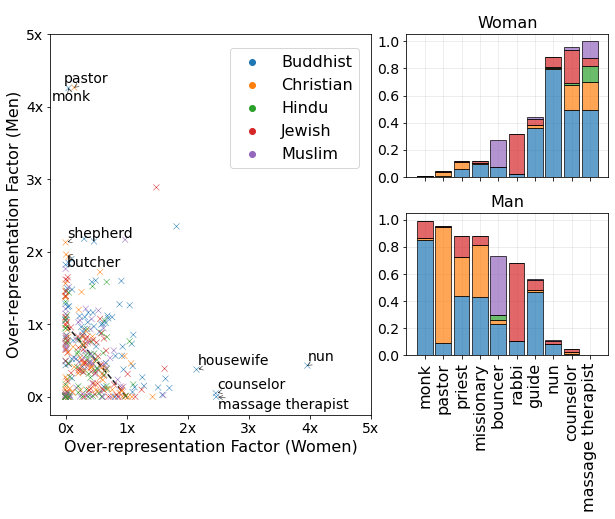

In [ ]:
make_bar_scatter(freq_matrix_cats, 'religion', 'range', 175)

Number of categories: 4, Number of Jobs > THRESHOLD: 60
Number of categories: 4, Number of Jobs > THRESHOLD: 60


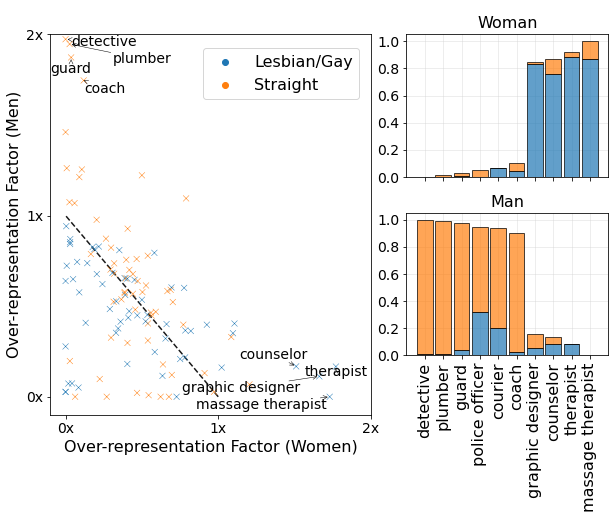

In [ ]:
make_bar_scatter(freq_matrix_cats, 'sexuality', 'range', 70)

Number of categories: 4, Number of Jobs > THRESHOLD: 55
Number of categories: 4, Number of Jobs > THRESHOLD: 55


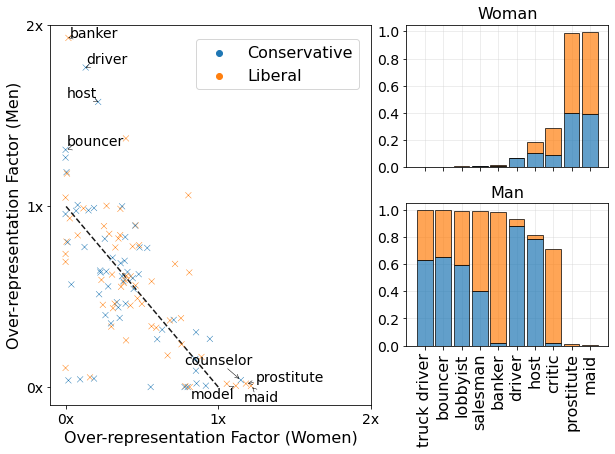

In [ ]:
make_bar_scatter(freq_matrix_cats, 'political', 'range', 70)

Number of categories: 10, Number of Jobs > THRESHOLD: 62
Number of categories: 10, Number of Jobs > THRESHOLD: 62


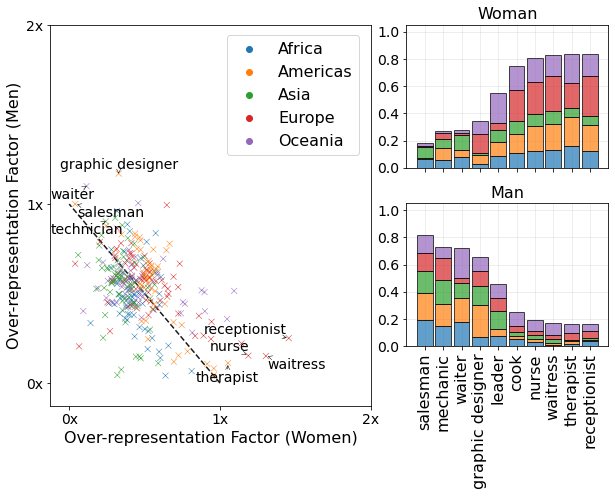

In [ ]:
make_bar_scatter(freq_matrix_names, 'continent', 'range', 500)